# Embedded Operator Splitting (EOS) Methods

This examples shows how to use the Embedded Operator Splitting (EOS) Methods described in Rein (2019). The idea is to embedded one operator splitting method inside another. The inner operator splitting method solves the Keplerian motion, whereas the outer solves the planet-planet interactions. The accuracy and speed of the EOS methods are comparable to standard Wisdom-Holman type methods. However, the main advantage of the EOS methods is that they do not require a Kepler solver. This significantly simplifies the implementation. And in certain cases this can lead to a speed-up by a factor of 2-3x.

In [1]:
import rebound
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import time
linestyles = ["--","-","-.",":"]
labels = {"LF": "LF", "LF4": "LF4", "LF6": "LF6", "LF8": "LF8", "LF4_2": "LF(4,2)", "LF8_6_4": "LF(8,6,4)", "PLF7_6_4": "PLF(7,6,4)", "PMLF4": "PMLF4", "PMLF6": "PMLF6"}

We first create a function to setup our initial conditions of two Jupiter-mass planets with moderate eccentricities . We also create a function to run the simulation and periodically measure the relative energy error. The function then runs the simulation again, this not only measuring the runtime. This way we don't include the time required to calculate the energy error in our run time measurements. 

In [2]:
def initial_conditions():
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(m=1e-3,a=1,e=0.05,f=0.)
    sim.add(m=1e-3,a=1.6,e=0.05,f=1.)
    sim.move_to_com()
    return sim
    
def run(sim):
    simc = sim.copy() # Use later for timing
    tmax = 100.
    
    # First run to measure energy error
    Emax = 0
    E0 = sim.energy()
    while sim.t<tmax:
        sim.integrate(sim.t+1.23456, exact_finish_time=0)
        E1 = sim.energy()
        Emax = np.max([Emax,np.abs((E0-E1)/E0)])
        
    # Second run to measuring run time
    start = time.time()        
    simc.integrate(tmax,exact_finish_time=0)
    end = time.time()

    return [Emax, end-start]

**Standard methods**

Let us first run a few standard methods. WH is the Wisdom-Holman method, WHC is the Wisdom-Holman method with symplectic correctors, and SABA(8,6,4) is a high order variant of the WH method. All methods except the LEAPFROG method use a Kepler solver. We run each method for 20 different timesteps, ranging from $10^{-4}$ to $0.3$ orbital periods of the innermost planet.

In [3]:
dts = 2.*np.pi*np.logspace(-4,-0.5,20)
methods = ["LEAPFROG", "WH", "WHC", "SABA(8,6,4)"]                        
results = np.zeros((len(dts), len(methods), 2))
for i, dt in enumerate(dts):
    for m, method in enumerate(methods):
        sim = initial_conditions()
        sim.dt = dt
        sim.integrator = method
        sim.ri_whfast.safe_mode = 0
        sim.ri_saba.safe_mode = 0
        results[i,m] = run(sim)

/Users/rein/git/rebound/rebound/simulation.py:675: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


We then plot the relative energy error as a function of the timestep on the left panel, and the relative energy error as a function of the run time on the right panel. In the right panel, methods further to the bottom left are more efficient. 

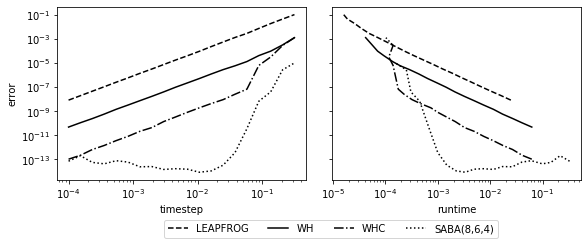

In [4]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plt.tight_layout()
for _ax in ax:
    _ax.set_xscale("log")
    _ax.set_yscale("log")
ax[0].set_xlabel("timestep");
ax[1].set_xlabel("runtime");
ax[0].set_ylabel("error")

for m, method in enumerate(methods):
    ax[0].plot(dts/np.pi/2.,results[:,m,0],label=method,color="black",ls=linestyles[m])
    ax[1].plot(results[:,m,1],results[:,m,0],label=method,color="black",ls=linestyles[m]) 

ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2), ncol=5);

**EOS with $\Phi_0=\Phi_1=LF$**

We now run several EOS methods where we set both the inner and outer operator splitting method to the standard second order leapfrog method. Our resulting EOS method will therefore also be a second order method. We vary the number of steps $n$ taken by $\Phi_1$.

In [5]:
ns = [1,2,4,8,16]
results_lf = np.zeros((len(dts), len(ns), 2))
for i, dt in enumerate(dts):
    for j, n in enumerate(ns):
        sim = initial_conditions()
        sim.dt = dt
        sim.integrator = "eos"
        sim.ri_eos.phi0 = "lf"
        sim.ri_eos.phi1 = "lf"
        sim.ri_eos.n = n
        sim.ri_eos.safe_mode = 0
        results_lf[i,j] = run(sim)

We can see in the following plot that for $n=1$, we recover the LEAPFROG method. For $n=16$ both the accuracy and efficiency of our EOS method is very similar to the standard WH method.

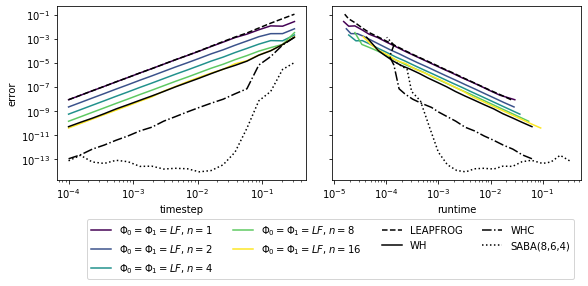

In [6]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plt.tight_layout()
for _ax in ax:
    _ax.set_xscale("log")
    _ax.set_yscale("log")
ax[0].set_xlabel("timestep");
ax[1].set_xlabel("runtime");
ax[0].set_ylabel("error")
colors = plt.cm.viridis(np.linspace(0,1,len(ns)))

for j, n in enumerate(ns):
    label = "$\Phi_0=\Phi_1=LF$, $n=%d$"%n
    ax[0].plot(dts/np.pi/2.,results_lf[:,j,0],label=label,color=colors[j])
    ax[1].plot(results_lf[:,j,1],results_lf[:,j,0],label=label,color=colors[j])

for m, method in enumerate(methods):
    ax[0].plot(dts/np.pi/2.,results[:,m,0],label=method,color="black",ls=linestyles[m])
    ax[1].plot(results[:,m,1],results[:,m,0],label=method,color="black",ls=linestyles[m]) 

ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2), ncol=4);

**An extra factor of $\epsilon$**

We now create EOS methods which are comparable to the Wisdom-Holman method with symplectic correctors. For the same timestep, the error is smaller by a factor of the mass ratio of the planet to the star, $\epsilon$. We set $\Phi_1$ to the fourth order LF4 method and use $n=2$. For $\Phi_0$ we try out LF4, LF(4,2) and PMLF4. 

In [7]:
phi0s = ["LF4", "LF4_2", "PMLF4"]
results_4 = np.zeros((len(dts), len(phi0s), 2))
for i, dt in enumerate(dts):
    for j, phi0 in enumerate(phi0s):
        sim = initial_conditions()
        sim.dt = dt
        sim.integrator = "eos"
        sim.ri_eos.phi0 = phi0
        sim.ri_eos.phi1 = "LF4"
        sim.ri_eos.n = 2
        sim.ri_eos.safe_mode = 0
        results_4[i,j] = run(sim)

We can see in the following plot that the EOS methods using LF(4,2) and PMLF4 do approach the accuracy and efficiency of the Wisdom-Holman method with symplectic correctors for small enough timesteps. To achieve a better accuracy for larger timesteps, we could increase the order of $\Phi_1$ or the number of steps $n$. Note that the EOS method with $\Phi_0=LF4$ is a true 4th order method, whereas the methods with LF(4,2) and PMLF4 have generalized order (4,2). 

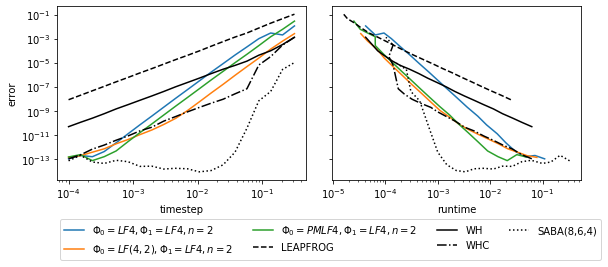

In [8]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plt.tight_layout()
for _ax in ax:
    _ax.set_xscale("log")
    _ax.set_yscale("log")
ax[0].set_xlabel("timestep");
ax[1].set_xlabel("runtime");
ax[0].set_ylabel("error")

for j, phi0 in enumerate(phi0s):
    label = "$\Phi_0=%s, \Phi_1=LF4, n=2$" % labels[phi0]
    ax[0].plot(dts/np.pi/2.,results_4[:,j,0],label=label)
    ax[1].plot(results_4[:,j,1],results_4[:,j,0],label=label)

for m, method in enumerate(methods):
    ax[0].plot(dts/np.pi/2.,results[:,m,0],label=method,color="black",ls=linestyles[m])
    ax[1].plot(results[:,m,1],results[:,m,0],label=method,color="black",ls=linestyles[m])   
    
ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2), ncol=4);

**High order methods**

Next, we will construct arbitrarily high order methods using LF, LF4, LF6, and LF8 for both $\Phi_0$ and $\Phi_1$. 

In [9]:
phis = ["LF", "LF4", "LF6", "LF8"]
results_2468 = np.zeros((len(dts), len(phis), 2))
for i, dt in enumerate(dts):
    for j, phi in enumerate(phis):
        sim = initial_conditions()
        sim.dt = dt
        sim.integrator = "eos"
        sim.ri_eos.phi0 = phi
        sim.ri_eos.phi1 = phi
        sim.ri_eos.n = 1
        sim.ri_eos.safe_mode = 0
        results_2468[i,j] = run(sim)

The following plots show that the methods are indeed 2nd, 4th, 6th, and 8th order methods.  

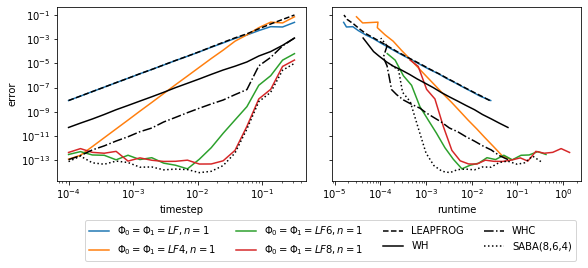

In [10]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plt.tight_layout()
for _ax in ax:
    _ax.set_xscale("log")
    _ax.set_yscale("log")
ax[0].set_xlabel("timestep");
ax[1].set_xlabel("runtime");
ax[0].set_ylabel("error")

for j, phi in enumerate(phis):
    label = "$\Phi_0=\Phi_1=%s, n=1$" % labels[phi]
    ax[0].plot(dts/np.pi/2.,results_2468[:,j,0],label=label)
    ax[1].plot(results_2468[:,j,1],results_2468[:,j,0],label=label)

for m, method in enumerate(methods):
    ax[0].plot(dts/np.pi/2.,results[:,m,0],label=method,color="black",ls=linestyles[m])
    ax[1].plot(results[:,m,1],results[:,m,0],label=method,color="black",ls=linestyles[m])   
    
ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2), ncol=4);

**Modified potentials**

We can use operator splitting methods which make use of derivatives of the acceleration, or the so called modified potential. For the same order, these methods can have fewer function evaluations, and thus better performance. Let us compare using the sixth order methods LF6 (nine function evaluations) and PMLF6 (three modified function evaluations) for $\Phi_0$. We keep using LF6 for $\Phi_1$. 

In [11]:
phis_m = ["LF6", "PMLF6"]
results_m = np.zeros((len(dts), len(phis_m), 2))
for i, dt in enumerate(dts):
    for j, phi in enumerate(phis_m):
        sim = initial_conditions()
        sim.dt = dt
        sim.integrator = "eos"
        sim.ri_eos.phi0 = phi
        sim.ri_eos.phi1 = "LF6"
        sim.ri_eos.n = 1
        sim.ri_eos.safe_mode = 0
        results_m[i,j] = run(sim)

In the following plot, we see that the method using PMLF6 is indeed about a factor of 2 faster than the one using LF6. 

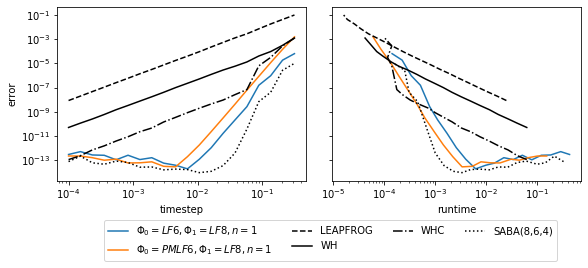

In [12]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plt.tight_layout()
for _ax in ax:
    _ax.set_xscale("log")
    _ax.set_yscale("log")
ax[0].set_xlabel("timestep");
ax[1].set_xlabel("runtime");
ax[0].set_ylabel("error")

for j, phi in enumerate(phis_m):
    label = "$\Phi_0=%s, \Phi_1=LF6, n=1$" % labels[phi]
    ax[0].plot(dts/np.pi/2.,results_m[:,j,0],label=label)
    ax[1].plot(results_m[:,j,1],results_m[:,j,0],label=label)

for m, method in enumerate(methods):
    ax[0].plot(dts/np.pi/2.,results[:,m,0],label=method,color="black",ls=linestyles[m])
    ax[1].plot(results[:,m,1],results[:,m,0],label=method,color="black",ls=linestyles[m])   
    
ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2), ncol=4);

**High order methods for perturbed systems**

We can do better than above by making use of high order methods for $\Phi_0$ which were specifically designed for perturbed systems such as LF(8,6,4) and PLF(7,6,4). 

In [13]:
phi0s_8 = ["LF8", "LF8_6_4", "PLF7_6_4"]
results_8 = np.zeros((len(dts), len(phi0s_8), 2))
for i, dt in enumerate(dts):
    for j, phi0 in enumerate(phi0s_8):
        sim = initial_conditions()
        sim.dt = dt
        sim.integrator = "eos"
        sim.ri_eos.phi0 = phi0
        sim.ri_eos.phi1 = "LF8"
        sim.ri_eos.n = 1
        sim.ri_eos.safe_mode = 0
        results_8[i,j] = run(sim)

We can see in the following plot that these methods indeed perform very well. With $\Phi_0=LF(8,6,4)$, $\Phi_1=LF8$ and $n=1$ we achieve an accuracy and efficiency comparable to SABA(8,6,4). In contrast to SABA(8,6,4) we do not require a Kepler solver. 

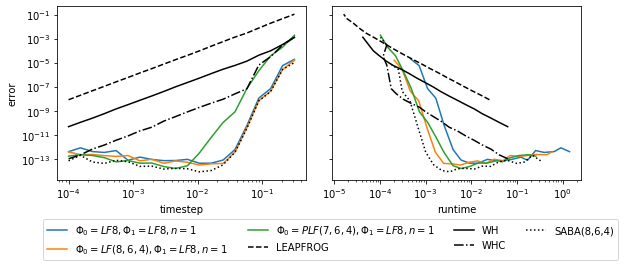

In [15]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plt.tight_layout()
for _ax in ax:
    _ax.set_xscale("log")
    _ax.set_yscale("log")
ax[0].set_xlabel("timestep");
ax[1].set_xlabel("runtime");
ax[0].set_ylabel("error")

for j, phi0 in enumerate(phi0s_8):
    label = "$\Phi_0=%s, \Phi_1=LF8, n=1$" % labels[phi0]
    ax[0].plot(dts/np.pi/2.,results_8[:,j,0],label=label)
    ax[1].plot(results_8[:,j,1],results_8[:,j,0],label=label)

for m, method in enumerate(methods):
    ax[0].plot(dts/np.pi/2.,results[:,m,0],label=method,color="black",ls=linestyles[m])
    ax[1].plot(results[:,m,1],results[:,m,0],label=method,color="black",ls=linestyles[m])   
    
ax[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.2), ncol=4);